In [1]:
import cv2
import os
import io
import random
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, TensorDataset
from PIL import Image
from torchvision import transforms
import uuid
import torch.optim as optim 

In [2]:
# Define paths inside Kaggle working directory
BASE_PATH = "/kaggle/working/data"
POS_PATH = os.path.join(BASE_PATH, "positive")
NEG_PATH = os.path.join(BASE_PATH, "negative")
ANC_PATH = os.path.join(BASE_PATH, "anchor")

# Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

print(f"Directories created:\n{POS_PATH}\n{NEG_PATH}\n{ANC_PATH}")

Directories created:
/kaggle/working/data/positive
/kaggle/working/data/negative
/kaggle/working/data/anchor


In [ ]:
import shutil

# Define paths
LFW_PATH = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled"  # Adjust this if needed
NEG_PATH = "/kaggle/working/data/negative"

# Copy LFW images to the negative data repository
if os.path.exists(LFW_PATH):
    for directory in os.listdir(LFW_PATH):
        dir_path = os.path.join(LFW_PATH, directory)
        if os.path.isdir(dir_path):  # Ensure it's a directory
            for file in os.listdir(dir_path):
                EX_PATH = os.path.join(dir_path, file)
                NEW_PATH = os.path.join(NEG_PATH, file)
                shutil.copy2(EX_PATH, NEW_PATH)  # ✅ Copy instead of moving

    print(f"All LFW images copied to {NEG_PATH}")
else:
    print(f"LFW dataset not found at {LFW_PATH}. Please check the dataset path.")

In [5]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down the frame to 250x250px
    frame = frame[120:120+250,200:200+250,:]

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create a unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image
        cv2.imwrite(imgname, frame)
        
    # Collect positive
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create a unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the inage show frame
cv2.destroyAllWindows()

In [2]:
BASE_PATH = "/kaggle/input/siamese-augmented/data"
POS_PATH = os.path.join(BASE_PATH, "positive")
NEG_PATH = os.path.join(BASE_PATH, "negative")
ANC_PATH = os.path.join(BASE_PATH, "anchor")

In [3]:
print(f"Directories created:\n{POS_PATH}\n{NEG_PATH}\n{ANC_PATH}")

Directories created:
/kaggle/input/siamese-augmented/data/positive
/kaggle/input/siamese-augmented/data/negative
/kaggle/input/siamese-augmented/data/anchor


In [ ]:
def augment_image(img):
    augmented_images = []
    
    # Define a series of transformations
    augmentation_pipeline = transforms.Compose([
        transforms.RandomApply([transforms.ColorJitter(brightness=0.02)], p=1.0),  # Adjust brightness randomly
        transforms.RandomApply([transforms.ColorJitter(contrast=0.4)], p=1.0),    # Adjust contrast randomly
        transforms.RandomHorizontalFlip(p=0.5),  # Flip image horizontally with 50% probability
        transforms.Lambda(lambda image: apply_random_jpeg_compression(image)),  # Apply random JPEG compression
        transforms.Lambda(lambda image: apply_random_saturation(image))  # Adjust saturation randomly
    ])

    # Generate 9 augmented variations of the input image
    for _ in range(9):
        modified_img = augmentation_pipeline(img)
        augmented_images.append(transforms.ToTensor()(modified_img))
    
    return augmented_images

# Function to simulate JPEG compression with random quality settings
def apply_random_jpeg_compression(img, min_quality=90, max_quality=100):
    chosen_quality = random.randint(min_quality, max_quality)
    img = img.convert('RGB')
    buffer = io.BytesIO()
    img.save(buffer, format="JPEG", quality=chosen_quality)
    img = Image.open(buffer)
    
    return img


# Function to randomly modify saturation levels
def apply_random_saturation(img, min_factor=0.9, max_factor=1.0):
    saturation_factor = random.uniform(min_factor, max_factor)
    return transforms.ColorJitter(saturation=saturation_factor)(img)

In [ ]:
def process_and_augment_images(directory, augmentation_function):
    """Loops through all images in the given directory, applies augmentation, and saves them."""
    valid_extensions = (".jpg", ".jpeg", ".png")

    for file_name in os.listdir(directory):
        if not file_name.lower().endswith(valid_extensions):
            print(f"Skipping non-image file: {file_name}")
            continue
            
        img_path = os.path.join(directory, file_name)
        
        # Load and convert image from BGR (OpenCV format) to RGB (PIL format)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping {file_name}: Unable to read file.")
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        # Apply augmentation function (returns a list of transformed images)
        augmented_images = augmentation_function(img)

        # Save augmented images
        save_augmented_images(OUTPUT_DIR, augmented_images)

def save_augmented_images(directory, images):
    """Saves a list of images to the given directory with unique filenames."""
    for img in images:
        # Convert tensor image back to NumPy format
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()
            img = np.uint8(img * 255)

        # Convert RGB back to BGR for OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # Generate a unique filename and save the image
        file_path = os.path.join(directory, str(uuid.uuid1()) + ".jpg")
        cv2.imwrite(file_path, img)

In [ ]:
# Call the function with the positive images directory
process_and_augment_images(POS_PATH, augment_image)

In [ ]:
process_and_augment_images(ANC_PATH, augment_image)
print("✅ Augmentation completed! Check /kaggle/working/augmented-images")

In [4]:
# Define the CustomDataset class
class CustomDataset(Dataset):
    def __init__(self, anchor_dir, positive_dir, negative_dir, transform=None):
        # Directories for the images
        self.anchor_files = [os.path.join(anchor_dir, f) for f in os.listdir(anchor_dir) if f.endswith('.jpg')][:3000]
        self.positive_files = [os.path.join(positive_dir, f) for f in os.listdir(positive_dir) if f.endswith('.jpg')][:3000]
        self.negative_files = [os.path.join(negative_dir, f) for f in os.listdir(negative_dir) if f.endswith('.jpg')][:3000]

        # Optional transform
        self.transform = transform

    def preprocess(self, file_path):
        # Open the image file
        img = Image.open(file_path).convert('RGB')

        # Define preprocessing transformations
        transform = transforms.Compose([
            transforms.Resize((100, 100)),    # Resize to 100x100
            transforms.ToTensor(),            # Convert image to tensor and scale between 0 and 1
        ])

        # Apply transformations
        img = transform(img)
        
        return img

    def __len__(self):
        # Return the total number of images in all categories
        return min(len(self.anchor_files), len(self.positive_files), len(self.negative_files))
    def __getitem__(self, idx):
        if idx >= len(self):
            raise StopIteration("Dataset exhausted")
            
        img1_path = self.anchor_files[idx]
        img2_path = self.positive_files[idx]
        img3_path = self.negative_files[idx]
        
        img1 = self.preprocess(img1_path)
        img2 = self.preprocess(img2_path)
        img3 = self.preprocess(img3_path)

       # Explicitly label each image
        label = torch.tensor([1, 1, 0], dtype=torch.float32)
    
        return img1, img2,img3, label


    def preprocess_twin(self, input_img, psitive_img, negative_img, label):
        """
        Preprocess pairs of images (anchor and positive/negative) and their label.
        """
        return (self.preprocess(input_img), self.preprocess(positive_img), self.preprocess(negative_img), label)

    def create_data(self):
        """
        Create a PyTorch dataset combining  positive, and negative samples.
        """
        positive_data = []
        for img_path in self.positive_files:
            img = self.preprocess(img_path)
            positive_data.append((img, torch.tensor(1)))  # Label 1 for positive samples

        # Create dataset for negative samples: label = 0 for negatives
        negative_data = []
        for img_path in self.negative_files:
            img = self.preprocess(img_path)
            negative_data.append((img, torch.tensor(0)))  # Label 0 for negative samples

        # Combine both positive and negative samples
        all_data = positive_data + negative_data 
    
        # Shuffle the dataset
        random.shuffle(all_data)

        return all_data

In [5]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Create the dataset
dataset = CustomDataset(anchor_dir=ANC_PATH, positive_dir=POS_PATH, negative_dir=NEG_PATH, transform=transform)

# Create the combined data (positive and negative samples)
combined_data = dataset.create_data()

# Split the dataset into training and testing datasets
train_size_try = int(0.7 * len(combined_data))
test_size_try = len(combined_data) - train_size_try
train_data_try, test_data_try = random_split(combined_data, [train_size_try, test_size_try])

# Create DataLoader for training and testing
train_data_loader_try = DataLoader(train_data_try, batch_size=16, shuffle=True, num_workers=2)
test_data_loader_try = DataLoader(test_data_try, batch_size=16, shuffle=False, num_workers=2)

# Example: Iterating through the DataLoader to check data
for imgs, labels in train_data_loader_try:
    print(imgs.shape)   
    print(labels)          # Labels for the images ([1, 0] for each triplet)
    break  # Stop after the first batch



torch.Size([16, 3, 100, 100])
tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0])


In [6]:
# from torch.utils.data import DataLoader, random_split

# Assuming CustomDataset is defined as you provided:
dataset = CustomDataset(anchor_dir=ANC_PATH, positive_dir=POS_PATH, negative_dir=NEG_PATH, transform=None)

# Calculate split sizes
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Sample 1: Pair Label = 0 (Anchor + Negative)
Sample 2: Pair Label = 0 (Anchor + Negative)
Sample 3: Pair Label = 1 (Anchor + Positive)
Sample 4: Pair Label = 1 (Anchor + Positive)
Sample 5: Pair Label = 0 (Anchor + Negative)


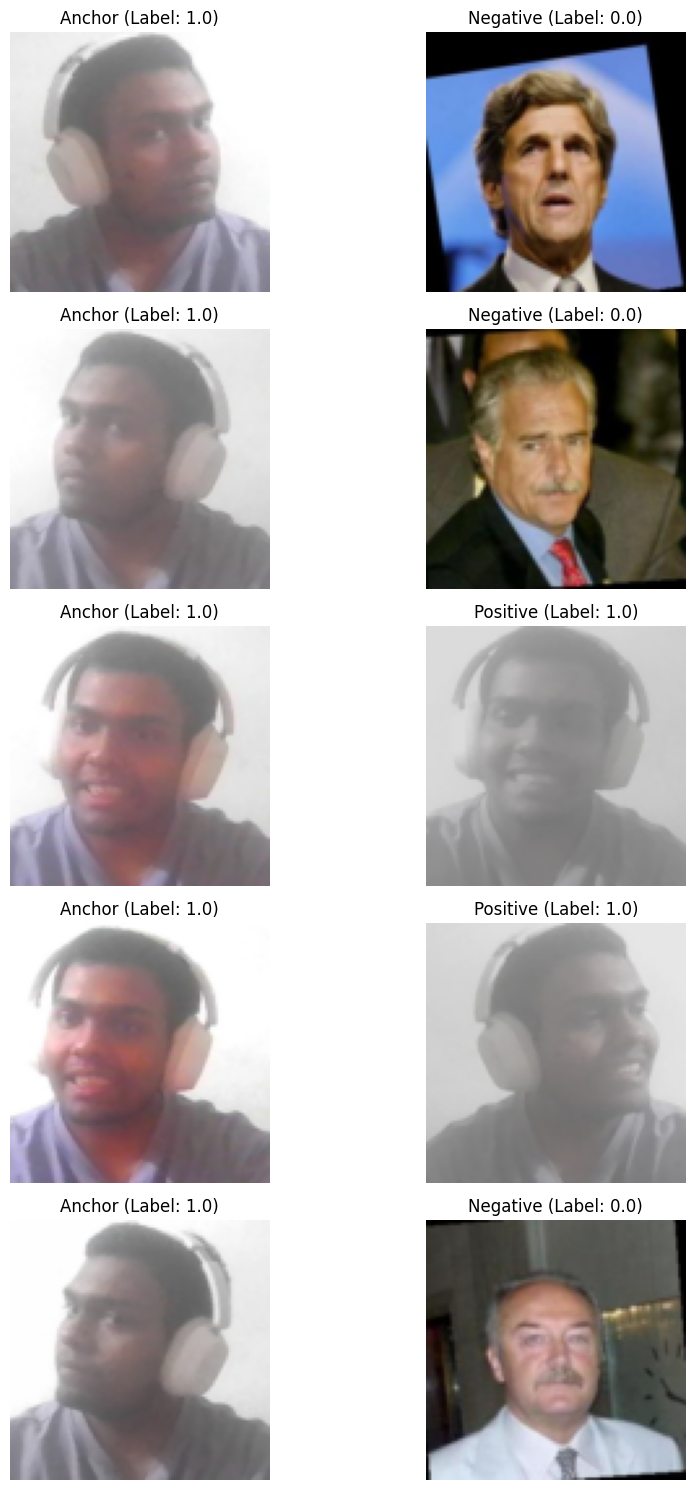

In [8]:
import matplotlib.pyplot as plt

def visualize_train_data_loader(train_data_loader, num_samples=5):
    # Get one batch of data
    for i, (img1, img2,img3, labels) in enumerate(train_data_loader):
        
        batch_size = len(img1)
        num_samples = min(num_samples, batch_size)
        
        # Plot the images
        fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))
        
        for idx in range(num_samples):
            if idx >= num_samples:  # Prevent errors if there are fewer images in the batch
                break
           # Randomly choose between img2 (positive) and img3 (negative)
            if random.choice([True, False]):
                chosen_img = img2[idx]
                chosen_label = labels[idx,1]
                chosen_title = "Positive"
                pair_label = 1
            else:
                chosen_img = img3[idx]
                chosen_label = labels[idx,2]
                chosen_title = "Negative"
                pair_label = 0
            
            anchor_img = img1[idx]
            anchor_label = labels[idx,0]  # Anchor label is always 1

            # Show anchor image
            axes[idx, 0].imshow(img1[idx].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
            axes[idx, 0].axis('off')
            axes[idx, 0].set_title(f"Anchor (Label: {anchor_label})")

            # Show randomly chosen image (positive or negative)
            axes[idx, 1].imshow(chosen_img.permute(1, 2, 0))
            axes[idx, 1].axis('off')
            axes[idx, 1].set_title(f"{chosen_title} (Label: {chosen_label})")

            print(f"Sample {idx + 1}: Pair Label = {pair_label} (Anchor + {chosen_title})")

        plt.tight_layout()
        plt.show()
        
        break

# Call the function with your train_data_loader
visualize_train_data_loader(train_data_loader)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TripleNetwork(nn.Module):
    def __init__(self, embedding_dim=128):
        super(TripleNetwork, self).__init__()
        
        # Feature Extractor (Shared CNN)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=10, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=7, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(128, 128, kernel_size=4, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Adaptive Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layers (Embedding Layer)
        self.fc1 = nn.Linear(256, embedding_dim)  # Reduced dimension
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward_one(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = F.relu(self.bn4(self.conv4(x)))

        
        x = self.global_avg_pool(x)
        return x  # Returns embeddings

    def forward(self, anchor, positive, negative):
        # Generate embeddings for both inputs
        anchor_embedding = self.forward_one(anchor)
        positive_embedding = self.forward_one(positive)
        negative_embedding = self.forward_one(negative)
    
        # Compute Cosine Similarity
        cosine_pos_sim = 1 -  F.cosine_similarity(anchor_embedding, positive_embedding, dim=1)
    
    
        # Classifier
        output = self.sigmoid(cosine_pos_sim)  # Reshape for FC layer
        return output, anchor_embedding, positive_embedding, negative_embedding

In [10]:
class TripletLossCosine(torch.nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLossCosine, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute Cosine Distance
        pos_sim =  1 - F.cosine_similarity(anchor, positive, dim=1)  # Anchor-Positive Distance
        neg_sim = 1 - F.cosine_similarity(anchor, negative, dim=1)  # Anchor-Negative Distance

        # Loss Calculation: Ensures positive pairs have higher similarity than negative pairs
        loss = torch.clamp(self.margin - neg_sim + pos_sim, min=0).mean()

        return loss

In [11]:
model = TripleNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = TripletLossCosine(margin=0.5)

anchor = torch.randn(16, 3, 100, 100)  # Batch of anchor images
positive = torch.randn(16, 3, 100, 100)  # Batch of positive images
negative = torch.randn(16, 3, 100, 100)  # Batch of negative images

output, anchor_embedding, positive_embedding, negative_embedding = model(anchor,positive,negative)

loss = criterion(anchor_embedding, positive_embedding, negative_embedding)

optimizer.zero_grad()
loss.backward()
optimizer.step()

print(f"Loss: {loss.item()}")

Loss: 0.49896615743637085


In [12]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [13]:
import numpy as np
import pandas as pd

def evaluate_siamese_network(model, data_loader, device, save_predictions=False, output_file="predictions.csv"):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []
    all_pred_probs = []  # Store the raw probabilities for all predictions
    all_true_labels = []  # Store true labels for comparison
    
    with torch.no_grad():  # Disable gradient computation for inference
        for batch in data_loader:
            img1, img2, img3, labels = batch
            img1 = img1.to(device)
            img2 = img2.to(device)
            img3 = img3.to(device)
            labels = labels.to(device).float() 

            # Forward pass
            outputs, anchor_embedding, positive_embedding, negative_embedding = model(img1, img2, img3)  # Model returns a tuple

            # Compute cosine distances
            positive_distance = 1 - F.cosine_similarity(anchor_embedding, positive_embedding)
            negative_distance = 1 - F.cosine_similarity(anchor_embedding, negative_embedding)
            
            preds = (positive_distance < negative_distance ).float()  
            true_labels = labels[:, 1]  # Extract "positive" labels from the tensor
            

            all_preds.append(preds.cpu().numpy())
            all_true_labels.append(true_labels.cpu().numpy())
            all_pred_probs.append(outputs.cpu().numpy())
            
    # Concatenate all batches
    all_preds = np.concatenate(all_preds).flatten()
    all_true_labels = np.concatenate(all_true_labels).flatten()
    all_pred_probs = np.concatenate(all_pred_probs).flatten()

    
    
    true_positives = ((all_preds == 1) & (all_true_labels == 1)).sum()
    false_positives = ((all_preds == 1) & (all_true_labels == 0)).sum()
    false_negatives = ((all_preds == 0) & (all_true_labels == 1)).sum()

    
    accuracy = true_positives / len(all_preds)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    

    
    if len(all_preds) == len(all_true_labels) == len(all_pred_probs):
        predictions_df = pd.DataFrame({
            "True Label": all_true_labels,
            "Predicted Class": all_preds,
            "Predicted Probability": all_pred_probs
        })
    else:
        print("Error: Mismatched lengths in data arrays")
        predictions_df = None

    return accuracy, precision, recall, f1, predictions_df
    

In [14]:
def train_siamese_network(model, train_loader, criterion, optimizer, num_epochs=10, device="cuda", save_predictions=False):
    model = model.to(device)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            img1, img2, img3, labels = batch
            img1 = img1.to(device)
            img2 = img2.to(device)
            img3 = img3.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs, anchor_embedding, positive_embedding, negative_embedding = model(img1, img2, img3)  # Model returns a tuple
            loss = criterion(anchor_embedding, positive_embedding, negative_embedding)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        
        accuracy, precision, recall, f1, predictions_df = evaluate_siamese_network(model, train_loader, device, save_predictions=save_predictions)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")

    print("Training complete!")
    return predictions_df

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)  # Move model to device first
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Then initialize the optimizer

train_siamese_network(
    device=device,
    model=model,
    train_loader=train_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=5
)

Epoch 1/5: 100%|██████████| 66/66 [00:28<00:00,  2.29it/s]


Epoch [1/5]
Train Loss: 0.1607 | Accuracy: 0.9924 | Precision: 1.0000 | Recall: 0.9924 | F1-score: 0.9962


Epoch 2/5: 100%|██████████| 66/66 [00:22<00:00,  2.88it/s]


Epoch [2/5]
Train Loss: 0.0601 | Accuracy: 0.9838 | Precision: 1.0000 | Recall: 0.9838 | F1-score: 0.9918


Epoch 3/5: 100%|██████████| 66/66 [00:21<00:00,  3.03it/s]


Epoch [3/5]
Train Loss: 0.0446 | Accuracy: 0.9929 | Precision: 1.0000 | Recall: 0.9929 | F1-score: 0.9964


Epoch 4/5: 100%|██████████| 66/66 [00:21<00:00,  3.12it/s]


Epoch [4/5]
Train Loss: 0.0369 | Accuracy: 0.9662 | Precision: 1.0000 | Recall: 0.9662 | F1-score: 0.9828


Epoch 5/5: 100%|██████████| 66/66 [00:21<00:00,  3.04it/s]


Epoch [5/5]
Train Loss: 0.0291 | Accuracy: 0.9671 | Precision: 1.0000 | Recall: 0.9671 | F1-score: 0.9833
Training complete!


,True Label,Predicted Class,Predicted Probability
0,1.0,1.0,0.530728
1,1.0,1.0,0.554404
2,1.0,1.0,0.548959
3,1.0,1.0,0.554844
4,1.0,1.0,0.578929
...,...,...,...
2095,1.0,1.0,0.533993
2096,1.0,1.0,0.511754
2097,1.0,1.0,0.513202
2098,1.0,1.0,0.539065
